<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Second-Assignment" data-toc-modified-id="Second-Assignment-1">Second Assignment</a></span><ul class="toc-item"><li><span><a href="#Condition-of-the-Matrices" data-toc-modified-id="Condition-of-the-Matrices-1.1">Condition of the Matrices</a></span></li><li><span><a href="#TSVD---First-Way" data-toc-modified-id="TSVD---First-Way-1.2">TSVD - First Way</a></span></li><li><span><a href="#TSVD---Second-Way" data-toc-modified-id="TSVD---Second-Way-1.3">TSVD - Second Way</a></span></li></ul></li></ul></div>

# Numerical Optimization & Large Scale Linear Algebra

------------------------------------------------------------------------------------------------

## Second Assignment


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import matrix_rank


In [2]:
datapath = '/data'

In [4]:
df = pd.read_csv(datapath,'\s',header = None, dtype = 'float')

C:\Users\akaplanis\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In order to create the matrices, it was my understanding that the the first row of df corresponds to the first four elements of the first row of A. Additionally the second row of df corresponds to the next four rows of the first row of A and so on and so forth. 

Given that, A's first row (A[0]) is equal to a[0:256] and the last row of A, A[255] = a(256x256 : 256x257)



In [5]:
a = df.stack()

Q = np.zeros((256*3,256))

In [6]:
for i in range(256*3):
    Q[i] = a[256*i: 256*(i+1)]
    

In [7]:
A = Q[0:256]
B = Q[256:512]
G = Q[512:768]


In [8]:
print("Length of df for each matrix =",len(df)/3,'\n--------------------------------------')

print("\nValidity of A's first element =", A[0,0] == df[0][0], A[0,0])
print("\nValidity of A's last element =", A[255,255] == df[3][len(df)/3 - 1] , A[255,255])

print("\n\nValidity of B's first element =", B[0,0] == df[0][len(df)/3], B[0,0])
print("\nValidity of B's last element =", B[255,255] == df[3][len(df)/3*2 - 1] , B[255,255])

print("\n\nValidity of G's first element =", G[0,0] == df[0][len(df)/3*2], G[0,0])
print("\nValidity of G's last element =", G[255,255] == df[3][len(df) - 1] , G[255,255])


Length of df for each matrix = 16384.0 
--------------------------------------

Validity of A's first element = True 0.02892211

Validity of A's last element = True 0.02892211


Validity of B's first element = True 0.02849913

Validity of B's last element = True 0.02849913


Validity of G's first element = True 0.22050029999999998

Validity of G's last element = True 0.1616731


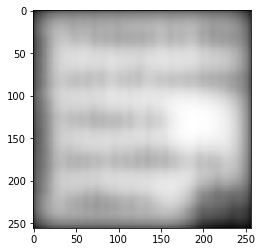

In [9]:
plt.imshow(G,cmap="gray")

# Truncated SVD

For the Truncated SVD I used two different ways. The first way seems more of a correct way and it leads up to the solution of problem 4. <br>The second way is based on the singular values of Sa and Sb to reduce dimensionality before the calculations in the expense of the better end result.

In [10]:
Ua, Sa, V_Ta = np.linalg.svd(A, full_matrices=False)

Ub, Sb, V_Tb = np.linalg.svd(B, full_matrices=False)

*Note: I understand that by transposing I add computational cost to the process but since the table is relatively of small size it helps with writing the code*

In [11]:
Va = V_Ta.T

Vb = V_Tb.T

In [12]:
#Turning image G in a vector
g = G.reshape((256**2), order = 'F')

# Initializing the deblurred image as a vector
f = np.zeros((256**2))

### Condition of the Matrices

In [13]:
S = np.kron(Sa,Sb)

In [14]:
CondA = Sa[0]/Sa[-1]
CondB = Sb[0]/Sb[-1]

CondK = np.max(S)/np.min(S)
print('CondA =',CondA,'\nCondB =',CondB,'\n\nCondK =',CondK)

CondA = 4533548.255271347 
CondB = 186510.54433611943 

CondK = 845554552864.7235


From a quick examination we observe that K is severely ill-conditioned. As a result even if we could solve the linear system Kf = g, our solution would be dominated by noise.

### TSVD - First Way 

From the plots below we observe some critical areas which we can use to reduce the size of Sa and Sb. <br> 
These are approximately at [i,i] = 40 and 50.<br> Especially after the 52nd element of Sa and 55th of Sb (approximately), we observe in both vectors that the singular values converge to 0. As a result from those points on we have more noise coming from Ua,Va and Ub,Vb rather than useful information.


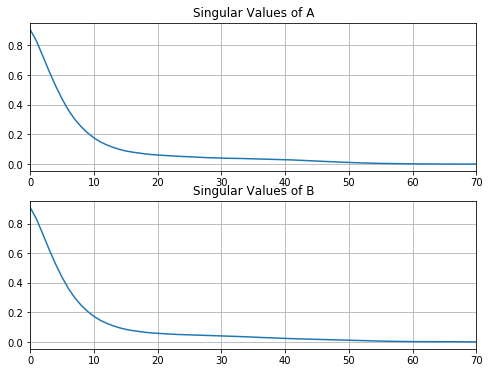

In [15]:
from matplotlib import figure
import matplotlib.pyplot as plt
plt.figure(figsize = (8,6))
plt.subplot(211)
plt.plot(Sa)
plt.xlim((0,70))
plt.grid(True)
plt.title('Singular Values of A')


plt.subplot(212)
plt.plot(Sb)
plt.title('Singular Values of B')
plt.xlim((0,70))
plt.grid(True)
plt.show()

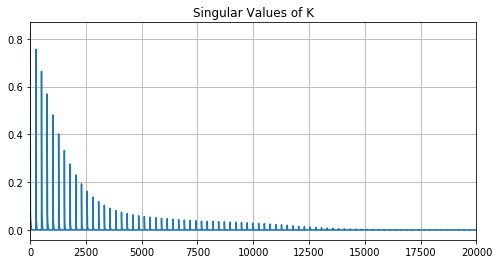

In [16]:
plt.figure(figsize = (8,4))
plt.plot(S)
plt.xlim((0,20000))
plt.title('Singular Values of K')
plt.grid(True)


In [17]:
S_indx = np.zeros((256*256,2))

for i in range(len(g)):
    S_indx[i] = (i//256,i-256*(i//256)) #create the respective indices of Sa and Sb inside S


S_indx = S_indx.astype(int)

S_sort = (-S).argsort() #sort the indices of S in descending order (sorted bt values of S)

In [18]:
p = [1000,2000,2500,3000,5000,10000] #truncation parameter

Instead of calculating the kronecker product of Ua,Ub and Va,Vb, I calculate iteratively the kronecker product of the i-th column of Ua and j-th column of Ub based on the k-th **largest** value of S. <br> 
This way we make sure that we will remove the noise from our end result. <br>
Essentially, instead of calculating a 256^2x256^2 matrix, I only calculate a vector of size 256^2 and add it to its self p-times 


In [19]:
imTSVD = np.zeros((256*256,6))

for k in range(len(p)):
    f = np.zeros(256*256)
    
    for i in range(p[k]):

        U_temp = np.kron(Ua[:,S_indx[S_sort[i]][0]],Ub[:,S_indx[S_sort[i]][1]]) #calculate the kron(Ua[:,i],Ub[:,j])
        V_temp = np.kron(Va[:,S_indx[S_sort[i]][0]],Vb[:,S_indx[S_sort[i]][1]]) #calculate the kron(Va[:,i],Vb[:,j])

        f += ((U_temp.T).dot(g)/S[S_sort[i]])*V_temp #use the formula of problem 4
        
    imTSVD[:,k] = f #store the vectors in a table which is used to view the images

In [20]:
imTSVD1 = imTSVD[:,0].reshape((256,256), order = 'F')
imTSVD2 = imTSVD[:,1].reshape((256,256), order = 'F')
imTSVD3 = imTSVD[:,2].reshape((256,256), order = 'F')
imTSVD4 = imTSVD[:,3].reshape((256,256), order = 'F')
imTSVD5 = imTSVD[:,4].reshape((256,256), order = 'F')
imTSVD6 = imTSVD[:,5].reshape((256,256), order = 'F')

In [21]:
#release storage
U_temp = 0
V_temp = 0
f=0 
imTSVD = 0


     TSVD - First Way   



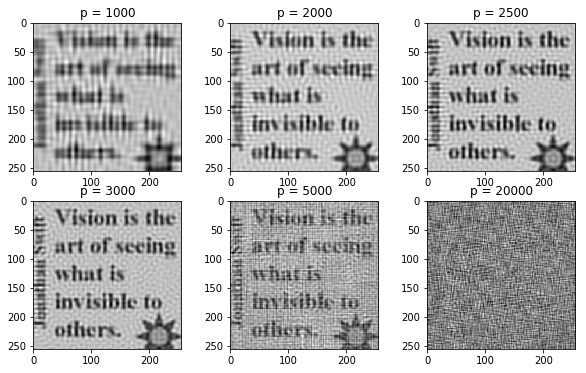

In [22]:
print('============================\n\n     TSVD - First Way   \n\n============================')
plt.figure(figsize = (10,6))
plt.subplot(231)
plt.imshow(imTSVD1,cmap="gray")
plt.title("p = 1000")
plt.subplot(232)
plt.imshow(imTSVD2,cmap="gray")
plt.title("p = 2000")
plt.subplot(233)
plt.imshow(imTSVD3,cmap="gray")
plt.title("p = 2500")
plt.subplot(234)
plt.imshow(imTSVD4,cmap="gray")
plt.title("p = 3000")
plt.subplot(235)
plt.imshow(imTSVD5,cmap="gray")
plt.title("p = 5000")
plt.subplot(236)
plt.title("p = 20000")
plt.imshow(imTSVD6,cmap="gray")


### TSVD - Second Way

In order to examine for possible differences I will use iteratively up to the 40th, 50th and 60th elements of Sa and Sb respectively. <br>
Then I calculate the kronecker products of Ua,Ub; Va,Vb and Sa,Sb. <br>
Next follows an estimation of g and using that we find an estimation of f.

In [23]:
lim = (40,50,60)

In [24]:
imTSVD = np.zeros((256*256,3))

for i in range(len(lim)):

    U_cut = np.kron(Ua[:,:lim[i]],Ub[:,:lim[i]]) #calculate the kron(Ua[:,:i],Ub[:,:i]) based on the limit set
    V_cut = np.kron(Va[:,:lim[i]],Vb[:,:lim[i]]) #calculate the kron(Va[:,:i],Vb[:,:i]) based on the limit set
    S_cut = np.kron(Sa[:lim[i]],Sb[:lim[i]]) #calculate the kron(Sa[:i],Sb[:i]) based on the limit set

    g_hat = U_cut.T.dot(g) #calculate the estimate of g

    f_hat = np.zeros(len(g_hat))

    for k in range(len(g_hat)):
        f_hat[k] = (g_hat[k])/(S_cut[k]) #calculate the estimate of f 


    f = V_cut.dot(f_hat) #calculate f
    
    imTSVD[:,i] = f


In [25]:
imTSVD7 = imTSVD[:,0].reshape((256,256), order = 'F')
imTSVD8 = imTSVD[:,1].reshape((256,256), order = 'F')
imTSVD9 = imTSVD[:,2].reshape((256,256), order = 'F')

In [26]:
#release storage
U_cut = 0
V_cut = 0
S_cut = 0
f=0 
imTSVD = 0


   TSVD - Second Way   



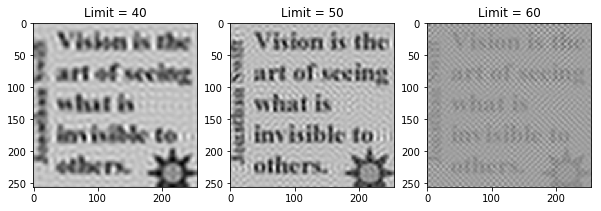

In [27]:
print('============================\n\n   TSVD - Second Way   \n\n============================')
plt.figure(figsize = (10,6))
plt.subplot(131)
plt.imshow(imTSVD7,cmap="gray")
plt.title("Limit = 40")
plt.subplot(132)
plt.imshow(imTSVD8,cmap="gray")
plt.title("Limit = 50")
plt.subplot(133)
plt.title("Limit = 60")
plt.imshow(imTSVD9,cmap="gray")



   TSVD - Final Results   



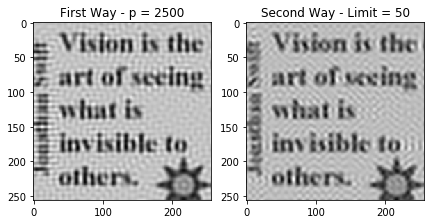

In [28]:
print('============================\n\n   TSVD - Final Results   \n\n============================')
plt.figure(figsize = (7,6))
plt.subplot(121)
plt.imshow(imTSVD3,cmap="gray")
plt.title("First Way - p = 2500")
plt.subplot(122)
plt.title("Second Way - Limit = 50")
plt.imshow(imTSVD8,cmap="gray")


Based on the above results we see that with the first way we get the best possible results out of the two. <br> This is obviously expected since by explicitly cutting out Sa and Sb and the 50th element we will definetely leave out some products that would produce higher values than the ones we have kept. <br> On the other hand, having kept the 50x50 largest values of S we leave out as much noise as possible and thus we get better results.

# Tikhonov Regularization

Once more, instead of calculating the kronecker product of Ua,Ub and Va,Vb, I calculate iteratively the kronecker product of the i-th column of Ua and j-th column of Ub based on the k-th value of S. <br>
<br> This time we do not need S to be sorted since we have a as a regulator. Using a we make sure to increase the filter's denominator (σ[i]^2+a^2) as needed in order to remove the noise.<br>

Again instead of calculating a 256^2x256^2 matrix, I only calculate a vector of size 256^2 and add it to itself 256^2-times 


In [29]:
a = [1,0.1,0.01,0.001,0.0001,0.00001]

In [30]:
imTikh = np.zeros((256*256,6))


for k in range(len(a)):
    f = np.zeros(256*256)
    
    for i in range(256*256):

        U_temp = np.kron(Ua[:,i//256],Ub[:,i-256*(i//256)]) #calculate the kron(Ua[:,i],Ub[:,j])
        V_temp = np.kron(Va[:,i//256],Vb[:,i-256*(i//256)]) #calculate the kron(Va[:,i],Vb[:,j])

        f += (S[i]*(U_temp.T).dot(g)/(S[i]**2+a[k]**2))*V_temp #use the formula of problem 3
        
    imTikh[:,k] = f #store the vectors in a table which is used to view the images


In [31]:
imTikh1 = imTikh[:,0].reshape((256,256), order = 'F')
imTikh2 = imTikh[:,1].reshape((256,256), order = 'F')
imTikh3 = imTikh[:,2].reshape((256,256), order = 'F')
imTikh4 = imTikh[:,3].reshape((256,256), order = 'F')
imTikh5 = imTikh[:,4].reshape((256,256), order = 'F')
imTikh6 = imTikh[:,5].reshape((256,256), order = 'F')

In [32]:
#release storage
U_temp = 0
V_temp = 0
f=0 
imTikh = 0


   Tikhonov Regularization   



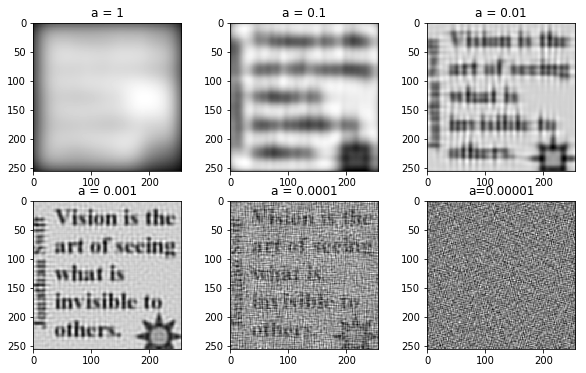

In [33]:
print('============================\n\n   Tikhonov Regularization   \n\n============================')
plt.figure(figsize = (10,6))
plt.subplot(231)
plt.imshow(imTikh1,cmap="gray")
plt.title("a = 1")
plt.subplot(232)
plt.imshow(imTikh2,cmap="gray")
plt.title("a = 0.1")
plt.subplot(233)
plt.imshow(imTikh3,cmap="gray")
plt.title("a = 0.01")
plt.subplot(234)
plt.imshow(imTikh4,cmap="gray")
plt.title("a = 0.001")
plt.subplot(235)
plt.imshow(imTikh5,cmap="gray")
plt.title("a = 0.0001")
plt.subplot(236)
plt.title("a=0.00001")
plt.imshow(imTikh6,cmap="gray")


Having acquired a first taste of the possible candidate values for a, we observe that for a = 0.001 we get the best result. <br>
Following this observation, I will try to optimize it further.

In [34]:
a = [0.0008,0.001,0.0015]

In [35]:
imTikh = np.zeros((256*256,6))


for k in range(len(a)):
    f = np.zeros(256*256)
    
    for i in range(256*256):

        U_temp = np.kron(Ua[:,i//256],Ub[:,i-256*(i//256)]) #calculate the kron(Ua[:,i],Ub[:,j])
        V_temp = np.kron(Va[:,i//256],Vb[:,i-256*(i//256)]) #calculate the kron(Va[:,i],Vb[:,j])

        f += (S[i]*(U_temp.T).dot(g)/(S[i]**2+a[k]**2))*V_temp #use the formula of problem 3
        
    imTikh[:,k] = f

In [36]:
imTikh7 = imTikh[:,0].reshape((256,256), order = 'F')
imTikh8 = imTikh[:,1].reshape((256,256), order = 'F')
imTikh9 = imTikh[:,2].reshape((256,256), order = 'F')

In [37]:
#release storage
U_temp = 0
V_temp = 0
f=0 
imTikh = 0


    Tikhonov Regularization - Optimization of a



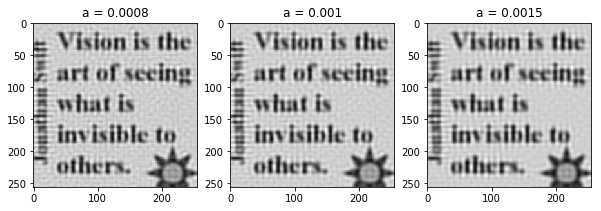

In [38]:
print('''========================================================\n\n    Tikhonov Regularization - Optimization of a\n
========================================================''')
plt.figure(figsize = (10,6))
plt.subplot(131)
plt.imshow(imTikh7,cmap="gray")
plt.title("a = 0.0008")
plt.subplot(132)
plt.imshow(imTikh8,cmap="gray")
plt.title("a = 0.001")
plt.subplot(133)
plt.title("a = 0.0015")
plt.imshow(imTikh9,cmap="gray")


Based on the above values, we can deduce that the best possible value for a given our data is in [0.001 , 0.0015] +/-0.0002. However whichever of these three values suffice, since further optimization does not produce any visible to the eyes difference. 

# Conclusion

Text(0.5, 1.0, 'Tikhonov - a = 0.001')

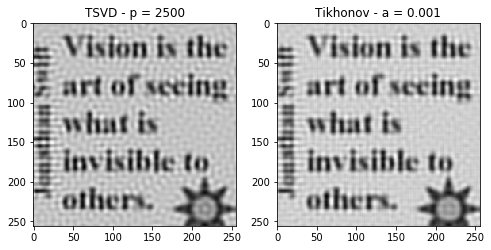

In [39]:
plt.figure(figsize = (8,6))
plt.subplot(121)
plt.imshow(imTSVD3,cmap="gray")
plt.title("TSVD - p = 2500")
plt.subplot(122)
plt.imshow(imTikh8,cmap="gray")
plt.title("Tikhonov - a = 0.001")

In conclusion, in our case and with the data at hand, both ways give satisfactory results (Tikhonov seems to produce slightly better results though). 